In [105]:
import pandas as pd
from pyod.models.knn import KNN

In [106]:
df = pd.read_csv('NASAFEMAData81220.csv')
df.drop(df[df['incidentType'] == 'Freezing'].index, inplace = True)
df.drop(df[df['incidentType'] == 'Fire'].index, inplace = True)
df.drop(df[df['declarationType'] == 'EM'].index, inplace = True)
df1 = df[['Time','Precip','geometry','COUNTYFP','GEOID','FEMAkey','disasterNumber','declarationType','incidentType']]
df2 = df1.sort_values(by=['geometry', 'Time'], ascending=[True, True])

/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (20,21,24,35,43,44,46,47,48,49,50,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [107]:
#yourdf=df2[df2.incidentType.where(df2.incidentType == 'Hurricane').bfill(limit=24).notnull()].copy()
#yourdf1=df2[df2.incidentType.where(df2.incidentType == 'Severe Storm(s)').bfill(limit=24).notnull()].copy()
#yourdf2=df2[df2.incidentType.where(df2.incidentType == 'Coastal Storm').bfill(limit=24).notnull()].copy()

In [108]:
#conv_2 = pd.concat([yourdf, yourdf1], axis=0)
#conv_3 = pd.concat([conv_2,yourdf2], axis = 0)

In [109]:
#df4 = conv_3.sort_values(by = ['geometry','Time'])

In [110]:
df4 = df2.sort_values(by = ['geometry','Time'])

In [111]:
f = lambda x: x.rolling(min_periods=1, window = 1).mean()
df5 = df4.groupby(['geometry','Time'], as_index=False)['Precip'].sum()
df5['Sum_of_prec_10'] = df5.groupby('geometry')['Precip'].apply(f).reset_index(drop=True, level=0)
df6 = df5

In [112]:
for i in range(2,20):
    f = lambda x: x.rolling(min_periods=1, window = i).mean()
    df5 = df4.groupby(['geometry','Time'], as_index=False)['Precip'].sum()
    name_1 = 'Sum_of' + str(i)
    df5[name_1] = df5.groupby('geometry', as_index=False)['Precip'].apply(f).reset_index(drop=True, level=0)
    name = 'Mean_' + str(i)
    df6[name] = df5[name_1]

In [113]:
df6 = df6.join(df2['incidentType'], how = 'left')

In [114]:
df6 = df6.join(df2['COUNTYFP'], how = 'left')

In [115]:
df6 =df6.fillna(0)

In [116]:
df6["COUNTYFP"] = df6["COUNTYFP"]. astype(float). astype(int)


In [117]:
#from sklearn.preprocessing import LabelEncoder
#Encoding bool_cols
#le = LabelEncoder()
#for i in ['geometry'] :
#    df6[i] = le.fit_transform(df6[i])

In [118]:
df7 =df6.fillna(0)

In [119]:
df8 = df7.replace("Severe Storm(s)",1)
df9 = df8.replace("Coastal Storm",1)
df10 = df9.replace("Hurricane",1)

In [120]:
df10["incidentType"] = df10["incidentType"].astype(int)

In [121]:
NasasubF = df10[df10.incidentType == False]

In [122]:
NasasubT = df10[df10.incidentType == True]

In [123]:
print(NasasubF.shape,NasasubT.shape)

(9933650, 24) (12846, 24)


In [124]:
NasasubF = NasasubF.sample(50000, replace = True)

In [125]:
NasasetM = pd.concat([NasasubF,NasasubT])

In [126]:
NasasetM.columns

Index(['geometry', 'Time', 'Precip', 'Sum_of_prec_10', 'Mean_2', 'Mean_3',
       'Mean_4', 'Mean_5', 'Mean_6', 'Mean_7', 'Mean_8', 'Mean_9', 'Mean_10',
       'Mean_11', 'Mean_12', 'Mean_13', 'Mean_14', 'Mean_15', 'Mean_16',
       'Mean_17', 'Mean_18', 'Mean_19', 'incidentType', 'COUNTYFP'],
      dtype='object')

In [180]:
columns_md = ['Mean_19']

In [181]:
X = NasasetM[columns_md]
y = NasasetM.incidentType

In [182]:
NasasetM.incidentType.unique()

array([0, 1])

In [183]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.25,random_state=0)

In [184]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
#
y_pred=logreg.predict(X_test)

In [185]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[12477,     0],
       [ 3235,     0]])

In [186]:
#One day
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.794106415478615
Precision: 0.0
Recall: 0.0


/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [187]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.89     12477
           1       0.00      0.00      0.00      3235

    accuracy                           0.79     15712
   macro avg       0.40      0.50      0.44     15712
weighted avg       0.63      0.79      0.70     15712



/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Trying Models

#### LogisticRegression

In [188]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.56
Accuracy of Logistic regression classifier on test set: 0.57


In [189]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.61      0.69     12477
           1       0.21      0.41      0.28      3235

    accuracy                           0.57     15712
   macro avg       0.51      0.51      0.49     15712
weighted avg       0.68      0.57      0.61     15712



#### DecisionTree

In [190]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(class_weight="balanced").fit(X_train, y_train)
y_pred=clf.predict(X_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.74


In [191]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83     12477
           1       0.37      0.38      0.37      3235

    accuracy                           0.74     15712
   macro avg       0.60      0.61      0.60     15712
weighted avg       0.74      0.74      0.74     15712



#### KNeighbors

In [192]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.83
Accuracy of K-NN classifier on test set: 0.77


In [193]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     12477
           1       0.40      0.19      0.26      3235

    accuracy                           0.77     15712
   macro avg       0.61      0.56      0.56     15712
weighted avg       0.73      0.77      0.74     15712



#### LinearDiscrimination

In [194]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred=lda.predict(X_test)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.80
Accuracy of LDA classifier on test set: 0.79


In [195]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.89     12477
           1       0.00      0.00      0.00      3235

    accuracy                           0.79     15712
   macro avg       0.40      0.50      0.44     15712
weighted avg       0.63      0.79      0.70     15712



/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### GaussianNB

In [196]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred=gnb.predict(X_test)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.80
Accuracy of GNB classifier on test set: 0.79


In [197]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.89     12477
           1       0.00      0.00      0.00      3235

    accuracy                           0.79     15712
   macro avg       0.40      0.50      0.44     15712
weighted avg       0.63      0.79      0.70     15712



/Users/lucasvalentich/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### SVC

In [145]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
y_pred=SVC.predict(X_test)

print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

TypeError: predict() missing 1 required positional argument: 'X'

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
NasasetM

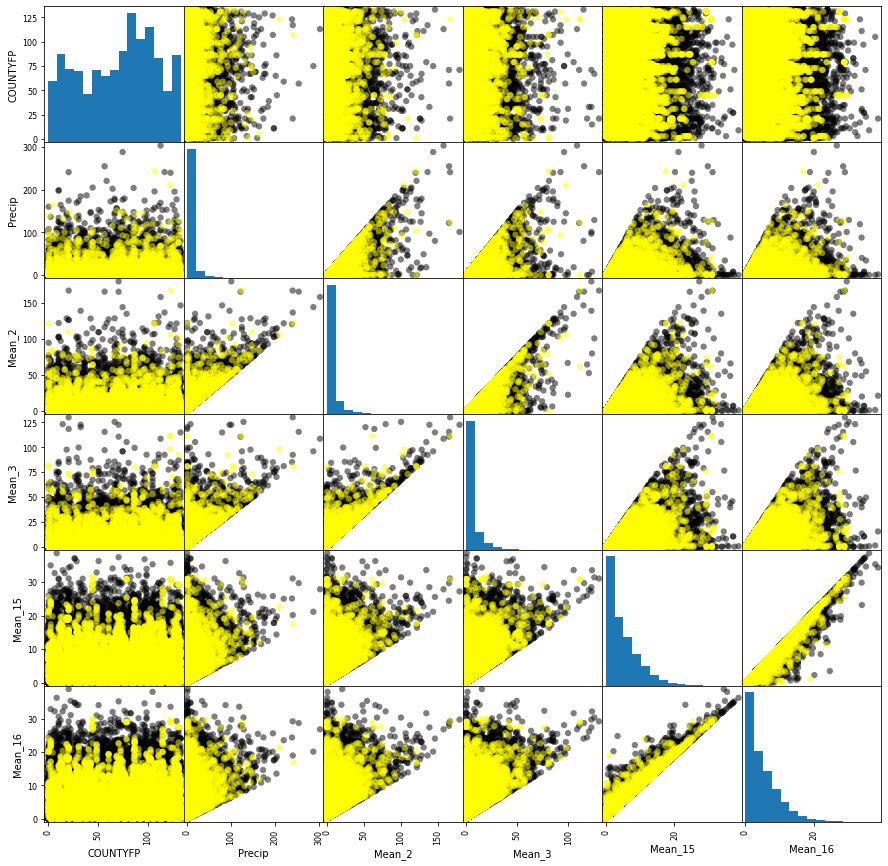

In [146]:
from pandas.plotting import scatter_matrix
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

feature_names = ['COUNTYFP','Precip', 'Mean_2', 'Mean_3',
       'Mean_15', 'Mean_16']
X = NasasetM[feature_names]
y = NasasetM['incidentType']
cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(15,15), cmap = cmap)



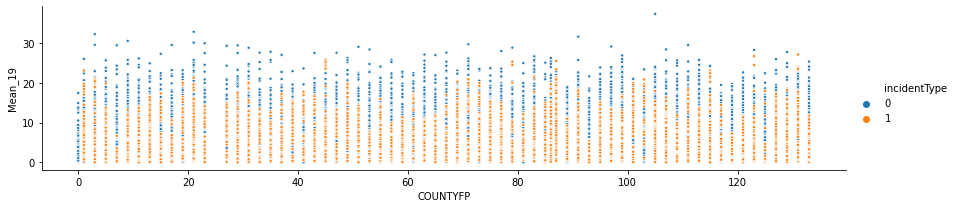

In [147]:
import seaborn as sns
df_graph = NasasetM[['Precip','incidentType','Mean_19','COUNTYFP']]

sns.relplot(x="COUNTYFP", y = 'Mean_19', hue="incidentType", data=df_graph, s = 10,height=3, aspect=4)


In [ ]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [ ]:
models = [
    SVC(gamma='auto'), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X, y, model)

In [ ]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['edible', 'poisonous'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)